## Machine Learning: Building a regression model using Lasso Regression

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

## IMPORTING THE CLEANED DATAFRAME
df_final = pd.read_csv('./CSV/df_merged_clean.csv')
#Print to ensure it is the right data frame
df_final

,Date,mean,std,volume,daily_return
0,2005-01-03,-0.500000,0.707107,2,-0.018395
1,2005-01-06,0.000000,0.000000,3,0.027972
2,2005-01-07,0.000000,0.000000,4,0.015306
3,2005-01-11,-0.333333,0.577350,3,-0.018487
4,2005-01-18,-1.000000,1.414214,2,-0.011986
...,...,...,...,...,...
1701,2023-08-07,0.000000,0.000000,3,0.028071
1702,2023-08-08,0.250000,2.179449,12,0.172622
1703,2023-08-09,1.444444,2.962731,9,-0.012815
1704,2023-08-10,-0.400000,1.776388,10,-0.012189


### Lasso Regression

In [18]:
# Splitting the data into features and target variable
X = df_final[['mean', 'std', 'volume']]  # Features
y = df_final['daily_return']  # Target variable

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Transforming the data set and creating interaction terms
poly_trans = PolynomialFeatures(degree=3, include_bias=False)
X_train_p = poly_trans.fit_transform(X_train)
X_test_p = poly_trans.transform(X_test)  # Use transform, not fit_transform for the test set

# Rescaling our data
rescaler = StandardScaler().fit(X_train_p)
X_train2 = rescaler.transform(X_train_p)
X_test2 = rescaler.transform(X_test_p)


In [19]:
# Creating a function that calculates the root mean squared error
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

output = []
# 20 values from 10^-4 to 10^4. Default base=10
lambdas = np.logspace(-4, 4, 20)

for lambda_ in lambdas:
    reg = Lasso(alpha=lambda_, random_state=1)
    reg.fit(X_train2, y_train)
    output.append(
        [
            lambda_,
            rmse(reg.predict(X_train2), y_train),
            rmse(reg.predict(X_test2), y_test),
        ]
    )

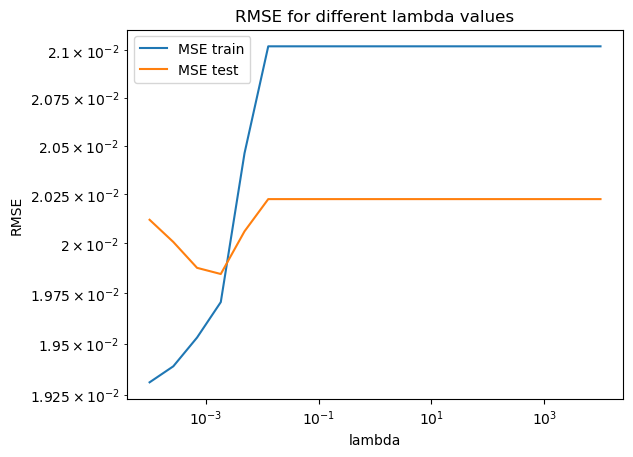

Minimum RMSE = 0.020 found for lambda = 0.0018.


In [20]:
# Visualization and selection of the optimal lambda cvalue
MSE_df = pd.DataFrame(
    data=output, columns=["lambda", "MSE train", "MSE test"]
).set_index("lambda")

MSE_df.plot(logx=True, logy=True)
plt.ylabel('RMSE')
plt.title('RMSE for different lambda values')
plt.show()

best_fit = MSE_df["MSE test"].nsmallest(1)
lambda_opt, RMSE_min = next(best_fit.items())
print(f"Minimum RMSE = {RMSE_min:.3f} found for lambda = {lambda_opt:.4f}.")

In [21]:
# After fitting the Lasso model
reg = Lasso(alpha=lambda_opt)
reg.fit(X_train2, y_train)

# Creating predicted values
y_pred = reg.predict(X_test2)

# Extracting coefficients and intercept
coefficients = reg.coef_
intercept = reg.intercept_

# Displaying the results
print("Intercept:", intercept)
print("\nCoefficients:")
for feature, coef in zip(poly_trans.get_feature_names_out(X.columns), coefficients):
    print(f"{feature}: {coef}")

Intercept: 0.0017132218697826493

Coefficients:
mean: 0.0
std: 0.0
volume: -0.0
mean^2: 0.0
mean std: 0.0
mean volume: 0.0015703412724797747
std^2: 0.0
std volume: -0.0
volume^2: -0.0
mean^3: 0.0
mean^2 std: 0.0
mean^2 volume: 0.0
mean std^2: -0.0
mean std volume: 0.0
mean volume^2: 0.0030963484746267876
std^3: 0.0
std^2 volume: 0.0
std volume^2: -0.0
volume^3: -0.002069015395105604


### Residuals Analysis

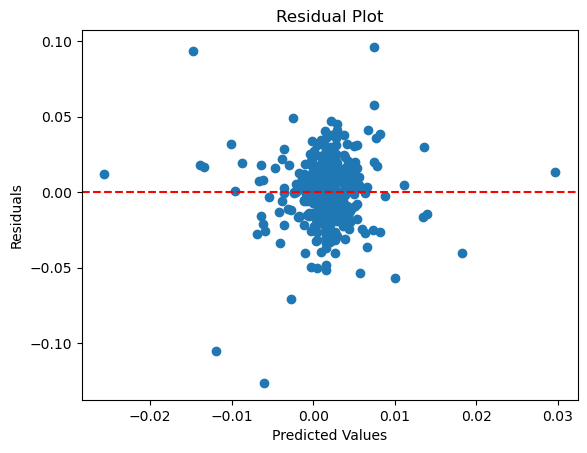

In [22]:
residuals = y_test - y_pred

# Plotting residuals
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')  # Adding a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Cross-Validation

In [23]:
# Using the optimal lambda value
reg = Lasso(alpha=lambda_opt)

# Computing cross-validated RMSE scores
scores = cross_val_score(reg, X_train2, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)

print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard Deviation of RMSE:", rmse_scores.std())

Cross-validated RMSE scores: [0.0180701  0.02073813 0.01846692 0.01823989 0.02329935]
Mean RMSE: 0.019762877417449778
Standard Deviation of RMSE: 0.0020160490859758204


#### Interpretation:

Our model, on average, has an error of about 0.0234 (23,4%). This is the typical difference between the observed values and the model's predictions.

The range of RMSE values across the 5 folds goes from around 0.017 to 0.036. This range gives you an idea of the best and worst-case scenarios for your model's performance on unseen data.

The standard deviation of the RMSE values across the folds is 0.00675. This indicates that there's some variability in how well the model performs on different subsets of the data. If this value were very high, it might be a cause for concern, as it would indicate that the model's performance is very inconsistent. In your case, while there's some variability, it's not excessively high.

In conclusion, cross-validation provides a more robust estimate of a model's performance than a single train-test split. By looking at the range and standard deviation of the RMSE values, you can get a sense of the model's consistency and reliability. If you're comparing multiple models, you'd typically choose the one with the lowest mean RMSE, provided its performance is consistent across folds (i.e., a low standard deviation of RMSE).

### Checking for multicolinarity

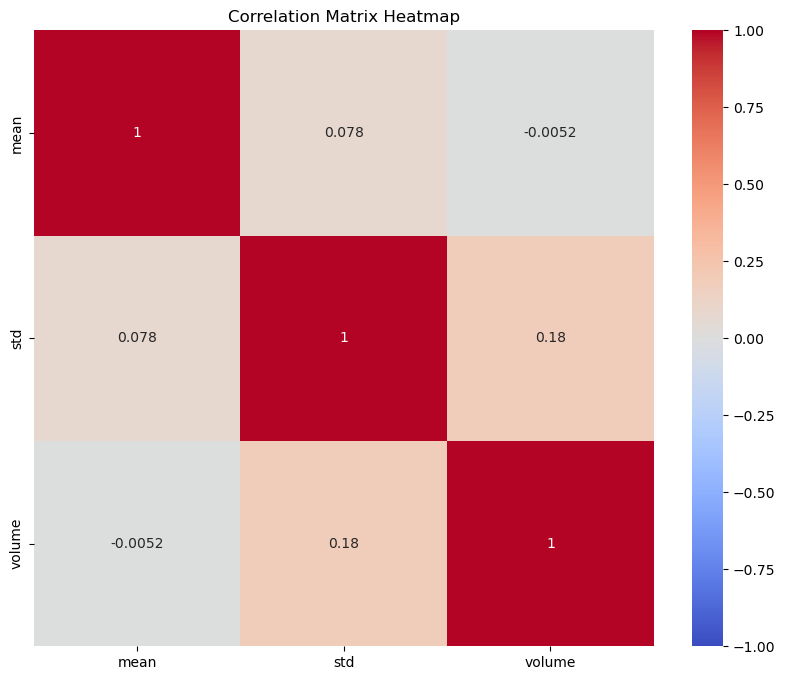

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_final[['mean', 'std', 'volume']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Trying to use categorical features and a logistic regression

In [45]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

# Creating a DataFrame 'xs' containing the features
xs = df_final[['mean', 'std', 'volume']]

# Convert 'daily_return' to binary (1 if positive, 0 if negative)
df_final['return_category'] = df_final['daily_return'].apply(lambda x: 1 if x > 0 else 0)
ys = df_final[['return_category']]
y = df_final[['daily_return']]

# Adding a constant (column of ones) to the features DataFrame
xs = sm.add_constant(xs)

# Setting up the logistic regression
logit_mod = Logit(ys, xs)
logit_res = logit_mod.fit(maxiter=200)
print(logit_res.summary().as_latex())

# If you also want to run an OLS regression:
OLS_mod = sm.OLS(y, xs)
OLS_res = OLS_mod.fit()
print(OLS_res.summary().as_latex())


# Tilføj interaktionsled evt. og lav ols med kontinuert 
# Bag of words + word count - tilføj deskriptiv  statistik om nyhedsartiklerne
# Key words der popper op i artiklerne mest - for at se hvad artiklerne snakker mest om
# Top fem key words
# I metode afsnit inkluder en redegørelse for hvorfro kvi har tilføjet alle ordene der filtrerer artikler
# Alle de ord vi har kategoriseret og brug til at filtrere, brug disse til at se hvor ofte en artikel indeholder disse ord for at argumentere for at vi har taget dem med

# Lav wikipedia plot - kan gøres ved hjælp af en pakke
# Find formlen hvor de forskellige indgår - dette vil være punkter på grafen, som skal plottes


Optimization terminated successfully.
         Current function value: 0.683457
         Iterations 4
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   & return\_category & \textbf{  No. Observations:  } &     1706    \\
\textbf{Model:}           &      Logit       & \textbf{  Df Residuals:      } &     1702    \\
\textbf{Method:}          &       MLE        & \textbf{  Df Model:          } &        3    \\
\textbf{Date:}            & Tue, 15 Aug 2023 & \textbf{  Pseudo R-squ.:     } &  0.009699   \\
\textbf{Time:}            &     12:26:01     & \textbf{  Log-Likelihood:    } &   -1166.0   \\
\textbf{converged:}       &       True       & \textbf{  LL-Null:           } &   -1177.4   \\
\textbf{Covariance Type:} &    nonrobust     & \textbf{  LLR p-value:       } & 4.361e-05   \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\

<Axes: xlabel='mean', ylabel='return_category'>

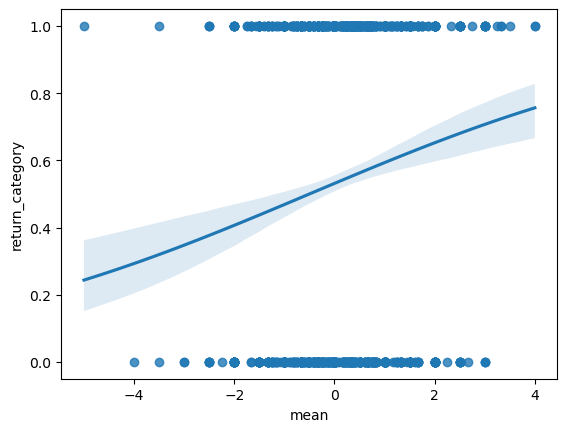

In [48]:
import seaborn as sns
x = df_final['mean']
sns.regplot(y = ys, x = x, data = df_final, logistic = True)